# Distance, Nearest Neighbors, and KMeans 

## Objectives

* Review various distance methods commonly used in data science
* Learn how distance is used to the application of K Nearest Neighbors
* Solving for means in clusters with K means
* learning how to interpret results from unsupervised learning

## Class Notes

### K Nearest Neighbors (KNN)

Nearest Neighbors is a seemingly simple enough algorithm, though in reality it is quite different from others learned so far, in terms of classification:

1. Many of the classifiers used so far are _discriminative_, that is, they draw decision lines to define and separate classes (with the exception of logistic regression). KNN is _generative_, meaning it learns the space defined for each class, and uses that as its decision line.
2. Many of the classifiers we've used also use exploratory rules to define classes (with the exception of support vector machines), such as odds and probability. KNN solves for class using _distance_ and _similarity_.

This makes KNN fairly intuitive to understand, though not very explanatory as a learner. Because of this, KNN fairs well as an _imputer_ (what is an imputer?). KNN essentially boils down to:

1. Pick a number for k and an observation features X and target y.
2. Find the k closest data points to the observation.
3. Whichever is the most common class of the neighbors in the target assignment.

### Distance Formulas

There are a variety of ways to calculate similar and distance. Below are a few common examples and when you'd expect to use them.

**Jaccard Coefficient / Jaccard Distance**

The Jaccard Coefficient follows logic of probability:

$J(A,B) = \dfrac{|A \cap B|}{|A \cup B}$

The above would read, "Jaccard's similarity coefficient between sets A and B would be the intersection of A and B divided by the union of A and B." 

A _union_ is all unique possible values from each set combined, while an _intersection_ is what they have in common. Consider these two sets defining two houses:

In [2]:
import pandas as pd

houses = pd.DataFrame({
        'rooms': [2, 1],
        'bathrooms': [1, 1],
        'stove': ['gas', 'electric'],
        'heat': ['radiator', 'radiator'],
})

houses

,bathrooms,heat,rooms,stove
0,1,radiator,2,gas
1,1,radiator,1,electric


The union of the two houses would contain the set:

bathrooms_1, heat_radiator, rooms_2, rooms_1, stove_gas, stove_electric

And the intersection would contain:

bathrooms_1, heat_radiator

We'd get a Jaccard coefficient of 0.333:

$\dfrac{len(intersection)}{len(union)} = \dfrac{2}{6}$

Jaccard's distance is just a matter of 1 - the similarity coefficient, so the distance of similarity between theses houses would be .667.

Jaccard's distance is great to use as a **distance metric for binary and categorical data**.

#### Minkowski distance (Manhattan, Euclidian)

**Manhattan Distance**


Think of Manhattan distance (or Taxi distance) as the distance to travel between two points given a grid like system (like Manhattan). So, if avenue and street blocks were the same distance, the Manhattan distance from Google (14th Street and 8th Ave) to the General Assembly (21st St and 5th Ave) would be 10 blocks. Manhattan distance is solved as:

$distance = \sum{|n_1 - n_2|}$

where $n$ is each feature. (_Sidebar: This is the same concept as L1 regularization_)

**Euclidean Distance**

$distance = \sum{\sqrt{(n_1 - n_2)^2}}$

Euclidean Distance is more similar to, say, helicopter distance: if we had to travel between two points, what would be the straight line taking us from point a to point b? (_Sidebar: This is the same concept as L2 regularization_)

**What to use?**

These two distances are summed up as *Minkowski distances*, Manhattan being Minkowski with a p of 1, and Euclidean being Minkowski with a p of 2. 

Both of these distance metrics work well with continuous data, though it is recommended to use **Manhattan distance when a distance set of 1 and 3 should be treated the same as a distance set of 2 and 2.** 

### Imputation with KNN

Imputation is fairly intuitive. For the missing data in our dataset, we're going to replace it with values that come from similar records in our dataset that aren't null. To do this we're going to use the NearestNeighbors algorithm. Even imputing, we will use a cross validation set.

In [3]:
from sklearn import cross_validation
df = pd.read_csv("../data/credit-data-post-import.csv")

train, test = cross_validation.train_test_split(df)
train = pd.DataFrame(train, columns=df.columns)
test = pd.DataFrame(test, columns=df.columns)

In [4]:
from sklearn.neighbors import KNeighborsRegressor

income_imputer = KNeighborsRegressor(n_neighbors=1)

# split our data into 2 groups; data containing nulls, and data not containing nulls.
# we'll train on the latter and make 'predictions' on the null data to impute monthly_income
train_w_monthly_income = train[train.monthly_income.isnull()==False]
train_w_null_monthly_income = train[train.monthly_income.isnull()==True]

In [5]:
correlations = train_w_monthly_income.corr()

# which columns are most correlated with monthly income?
# This will be one quick way to help us find our KNN features

monthly_income_correlations = pd.Series(correlations.ix[:, 5])
monthly_income_correlations.order(ascending=False)

monthly_income                                 1.000000
number_real_estate_loans_or_lines              0.167065
number_of_open_credit_lines_and_loans          0.121497
number_of_dependents                           0.077896
age                                            0.050929
revolving_utilization_of_unsecured_lines       0.009674
number_of_time30-59_days_past_due_not_worse   -0.012119
number_of_time60-89_days_past_due_not_worse   -0.013689
number_of_times90_days_late                   -0.015690
serious_dlqin2yrs                             -0.025591
debt_ratio                                    -0.041366
Name: monthly_income, dtype: float64

In [6]:
cols = ['number_real_estate_loans_or_lines', 'number_of_open_credit_lines_and_loans']

income_imputer = KNeighborsRegressor(n_neighbors=1, p=2)
income_imputer.fit(train_w_monthly_income[cols], train_w_monthly_income.monthly_income)

# fill in the missing data with the imputed values!
train_w_null_monthly_income['monthly_income'] = income_imputer.predict(train_w_null_monthly_income[cols])

test['monthly_income_imputed'] = income_imputer.predict(test[cols])
test[['monthly_income', 'monthly_income_imputed']].head()


/Users/ed/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


,monthly_income,monthly_income_imputed
0,NaN,10833
1,5200,1400
2,4966,3761
3,5547,6335
4,NaN,5870


In [7]:
income_imputer = KNeighborsRegressor(n_neighbors=2, p=2)
income_imputer.fit(train_w_monthly_income[cols], train_w_monthly_income.monthly_income)

# fill in the missing data with the imputed values!
train_w_null_monthly_income['monthly_income'] = income_imputer.predict(train_w_null_monthly_income[cols])

test['monthly_income_imputed'] = income_imputer.predict(test[cols])
test[['monthly_income', 'monthly_income_imputed']].head()


/Users/ed/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


,monthly_income,monthly_income_imputed
0,NaN,10416.5
1,5200,4843.5
2,4966,2838.5
3,5547,4017.5
4,NaN,5435.0


In [8]:
from sklearn import grid_search

imputer = KNeighborsRegressor()
parameters1 = {'p': (1, 2), 'n_neighbors': range(1, 23, 3)}

regr = grid_search.GridSearchCV(imputer, parameters1, scoring='mean_squared_error')
regr.fit(train_w_monthly_income[cols], train_w_monthly_income.monthly_income)

GridSearchCV(cv=None,
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_neighbors=5, p=2, weights='uniform'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'p': (1, 2), 'n_neighbors': [1, 4, 7, 10, 13, 16, 19, 22]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='mean_squared_error', verbose=0)

In [9]:
parameters2 = {'metric': ['jaccard'], 'n_neighbors': range(1, 23, 3)}
jac = grid_search.GridSearchCV(imputer, parameters2, scoring='mean_squared_error')
jac.fit(train_w_monthly_income[cols], train_w_monthly_income.monthly_income)

GridSearchCV(cv=None,
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_neighbors=5, p=2, weights='uniform'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_neighbors': [1, 4, 7, 10, 13, 16, 19, 22], 'metric': ['jaccard']},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='mean_squared_error', verbose=0)

In [14]:
print "----------Minkowski Grid Search-------------"
for score in regr.grid_scores_:
    print score

print regr.best_estimator_ 

print "----------Jaccard Grid Search-------------"
for score in jac.grid_scores_:
    print score

print jac.best_estimator_ 

----------Minkowski Grid Search-------------
mean: -130131036.32925, std: 38433896.47958, params: {'n_neighbors': 1, 'p': 1}
mean: -130163369.59402, std: 38448800.33376, params: {'n_neighbors': 1, 'p': 2}
mean: -127226629.72560, std: 40537905.23942, params: {'n_neighbors': 4, 'p': 1}
mean: -127232797.51174, std: 40547004.51989, params: {'n_neighbors': 4, 'p': 2}
mean: -119730344.33705, std: 39582600.56127, params: {'n_neighbors': 7, 'p': 1}
mean: -119733826.77955, std: 39588618.51385, params: {'n_neighbors': 7, 'p': 2}
mean: -116797837.82833, std: 39876958.74819, params: {'n_neighbors': 10, 'p': 1}
mean: -116678375.90207, std: 39788584.14816, params: {'n_neighbors': 10, 'p': 2}
mean: -115917056.32960, std: 38943411.74158, params: {'n_neighbors': 13, 'p': 1}
mean: -115867179.25386, std: 39029886.67435, params: {'n_neighbors': 13, 'p': 2}
mean: -114841479.15327, std: 39548877.14346, params: {'n_neighbors': 16, 'p': 1}
mean: -114818602.84927, std: 39611350.59429, params: {'n_neighbors': 1

Read through the results of the grid search above and take a few minutes to answer the following questions:

1. Which parameter setting performed the best? Which performed the worst?
2. Do we notice any differences between the values for k neighbors?
3. Do we notice any differences between Manhattan (p=1) and Euclidean (p=2)?
4. Do we notice any differences between Minkowski and Jaccard?



Let's walk through the same example, but using Neighbors in its more common form as a classifier. In this case, we'll classify the iris flowers.

In [15]:
from sklearn import grid_search, datasets
from sklearn.neighbors import KNeighborsClassifier
iris = datasets.load_iris()
parameters = {'p': [2], 'n_neighbors':range(1, 100)}
knn = KNeighborsClassifier()
clf = grid_search.GridSearchCV(knn, parameters, scoring='accuracy')
clf.fit(iris.data, iris.target)                            

GridSearchCV(cv=None,
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'p': [2], 'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='accuracy', verbose=0)

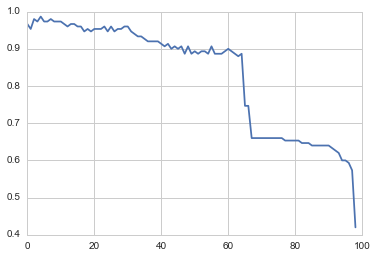

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
scores = [i.mean_validation_score for i in clf.grid_scores_]
plt.plot(scores)

Take a few minutes to answer these questions:

1. What happens to the accuracy of the algorihm as there are more neighbors used?
2. Why do you think the accuracy suddently drops around 65 neighbors on the iris data set?
3. Why again at 100 neighbors?

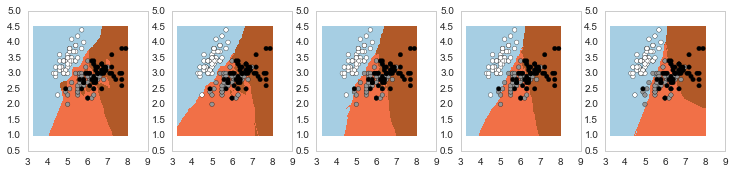

In [17]:
import numpy as np
def plot_estimator(estimator, X, y, ax, pos):
    estimator.fit(X,y)
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + .1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + .1
    xx, yy =np.meshgrid(np.linspace(x_min, x_max, 100),
                        np.linspace(y_min, y_max, 100))
    
    # perform classification on our samples
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])
                        
    # Put the result into a color plot
    Z = Z.reshape (xx.shape)
    ax[pos].pcolormesh(xx,yy, Z, cmap=plt.cm.Paired)
                        
    # Lets plot our sample points
    ax[pos].scatter(X[:,0], X[:,1], c=y)
    
fig, axes = plt.subplots(1, 5, figsize=[12.5, 2.5])
for e, k in enumerate([1, 5, 40, 60, 100]):
    plot_estimator(KNeighborsClassifier(n_neighbors=k), iris.data[:,:2], iris.target, axes, e)
    

### Caveats about K Nearest Neighbors

* Training Neighbors is a huge cost ($n^2$). This essentially means for every observation, it takes that amount of time _squared_ to compute. So 2 observations = 4 compute, 4 observations = 16 compute. In contrast, a regression would take just as long to compute (roughly) the number of features equal to the number of observations for KNN.
* What happens if we train for 4 neighbors and the nearest are 2 of each class? Most algorithms run on a sort, so it just picks the "first" one that hit 2 values, but is that the right assumption to make? What steps could be made to avoid it?
* It's arguable that with increased dimensions (more features) points eventually become equidistant. This implies KNN would work better with less features.

### K Means

#### What is unsupervised learning?

KNN is another example of supervised learning: machine learning techniques used when we already know what the target variable looks like, and we want to either _classify_ or _regress_ to solve for y. What happens if we don't know?

Primary unsupervised learning principles:

* **Dimensionality Reduction** A technique to reducing the number of features that exist , most often maintaining the variance of the data.

* **Clustering** A technique of creating new structure, often using distance or similarity as a guideline.

Keep in mind the similarities here; **clustering** is unsupervised, **classification** is supervised (we already know the answer)

#### How does clustering work?

A simpler clustering example would be hierarchical clustering. Consider these examples:

<img src="img/fruit_clustering.gif">
<img src="img/mileage_clustering.png">

1. A distance or similarity metric is applied to the data.
2. Each point begins as its own cluster.
3. Each cluster is paired to its closest match
4. Repeat until left with one cluster.
5. Define a distance or dissimilairty point to solve for clusters.

#### How is K Means different?

Hierarchical clustering does not pre define the clusters, it simply "walks" from clusters = number of observations to clusters = 1. **K Means**, instead, solves for a given or expected K clusters. This means that just like KNN, we need to solve for K.


#### How does K Means work?

K Means is an **iterative** formula, meaning it will repeat steps until the solution is found (or converged):

1. K Means will initially pick K random points in the dimensional space (K is something you will define). These points are called **centroids**.
2. All observations then calculate distances to each centroid, the closest centroid will be which cluster it belongs to.
3. Discarding the centroid, the mean distance point is determined based on observations for each cluster; this "mean" is now the new centroid.
4. Repeat steps 2 and 3 until the old and new centroid are the same.

<img src="img/kmeans.png" width="720">

### How do we know what K is correct?

The rule of thumb: K = half of the number of observations. This, if anything, is a good starting point, but not the end all solution.

One common approach is the elbow rule: how many clusters are required to explain the variance of the data set? We can use these rules to help define that:

1. One cluster will explain the most, on its own.
2. Clusters k = n (number of observations) will explain 100% of the variance in the data.
3. We want a set of clusters that offer the most explanation; adding any more would be marginal.

This technique is called **the elbow rule** and applies to many concepts of unsupervised learning! Let's apply it to the iris data set:

(1, 75)

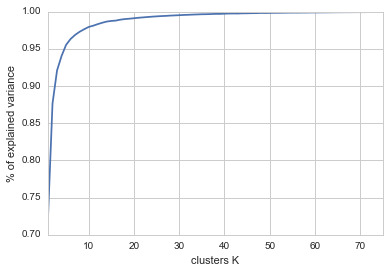

In [55]:
from sklearn import cluster
from __future__ import division

sepal_data = iris.data[:, :2]
krange = range(1, int(sepal_data.shape[0] / 2))
sum_squares = [cluster.KMeans(n_clusters=k).fit(sepal_data).inertia_ for k in krange]

variance_explained = [1.0 - (s / sum(sum_squares)) for s in sum_squares]
plt.figure()
plt.plot(range(1, 75), variance_explained)
plt.ylabel('% of explained variance')
plt.xlabel('clusters K')
plt.xlim([1, 75])

It looks like we bend much earlier than 75, so let's zoom in a bit...

(1, 11)

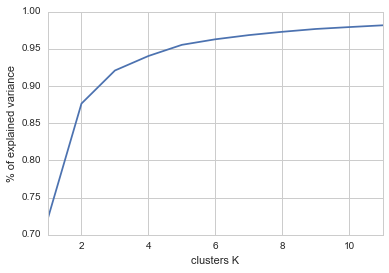

In [54]:
plt.figure()
plt.plot(range(1, 12), variance_explained[:11])
plt.ylabel('% of explained variance')
plt.xlabel('clusters K')
plt.xlim([1, 11])

It seems like the right amount of clusters for us would be roughly 3 or 4, at which point after adding clusters seems to explain less and less of the variance. We see 3 clusters defines at least 90% of the variance, which is a great bend point to use.

#### Visualising K Means

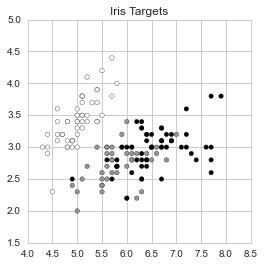

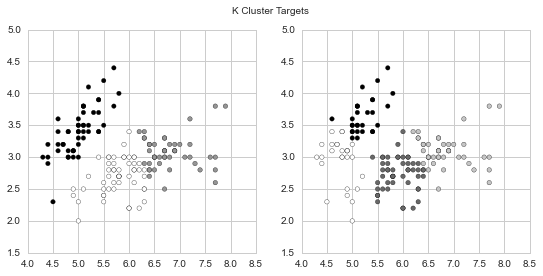

In [40]:
## -- Actual --
plt.figure(figsize=[4, 4])
plt.scatter(sepal_data[:, 0], sepal_data[:, 1], c=iris.target)
plt.title('Iris Targets')

## -- 3 Clusters --
clusters_3 = cluster.KMeans(n_clusters=3).fit(sepal_data)
fig, ax = plt.subplots(1, 2, figsize=[9, 4])
fig.suptitle('K Cluster Targets')
ax[0].scatter(sepal_data[:, 0], sepal_data[:, 1], c=clusters_3.predict(sepal_data))

## -- 4 Clusters --
clusters_4 = cluster.KMeans(n_clusters=4).fit(sepal_data)
ax[1].scatter(sepal_data[:, 0], sepal_data[:, 1], c=clusters_4.predict(sepal_data))


#### How do we interpret Clusters?

The simplest way would be to apply a set of rules. What's a machine learning technique that we can use to define rules?

In [57]:
from sklearn import tree

# fit a classification tree with max_depth=2 on all data
treeclf = tree.DecisionTreeClassifier(max_depth=2, random_state=1)
treeclf.fit(sepal_data, clusters_3.predict(sepal_data))

# create a Graphviz file
with open("iris_clusters.dot", 'wb') as f:
    f = tree.export_graphviz(treeclf, out_file=f, feature_names=iris.feature_names[:3])

<img src='img/iris_clusters.png'>

## Additional Resources

* A more elementary way to think about kmeans is available from [this video](https://www.youtube.com/watch?v=0MQEt10e4NM)
* [Another walkthrough](http://nbviewer.ipython.org/github/alpinedatalabs/ODST/blob/master/notebooks/D3.%20K-Means%20Clustering%20Analysis.ipynb) of kmeans, though it interacts directly with the scipy version. Try to rewrite it using sklearn and see if you get similar results!
* [More detail on the caveats of kmeans](http://nbviewer.ipython.org/github/BartBaddeley/PyDataTalk-2014/blob/master/PyDataTalk.ipynb) because while the idea and algorithm are relatively simple, the results are crude, and often, not what we want!
* read through an additional metric, [the silhouette coefficient](http://en.wikipedia.org/wiki/Silhouette_(clustering)), to learn more about poor cluster assignment
* A more in depth read on [clustering](http://www-users.cs.umn.edu/~kumar/dmbook/ch8.pdf) from  the book _Introduction to Data Mining_
* SKlearn includes a strong [overview](http://scikit-learn.org/stable/modules/clustering.html) of the techniques available.
